In [123]:
import numpy as np
import matplotlib.pyplot as plt

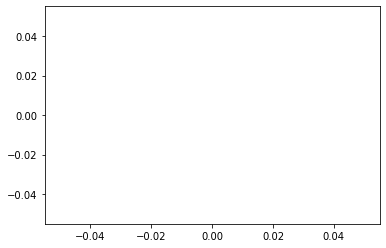

In [2]:
plt.plot()


In [2]:
import gym
import gym_chess

In [14]:
env = gym.make('ChessVsRandomBot-v0')
env.render(mode='human')


    -------------------------
 8 |  ♖  .  .  .  ♔  .  .  ♖ |
 7 |  ♙  .  .  .  .  .  .  ♙ |
 6 |  .  .  .  .  .  .  .  . |
 5 |  .  .  .  .  .  .  .  . |
 4 |  .  .  .  .  .  .  .  . |
 3 |  .  .  .  .  .  .  .  . |
 2 |  ♟  .  .  .  .  .  .  ♟ |
 1 |  ♜  .  .  .  ♚  .  .  ♜ |
    -------------------------
      a  b  c  d  e  f  g  h 



In [16]:
env.QUEEN_CATSLE

2

In [17]:
moves = env.get_possible_moves(env.state, 1)
# m = random.choice(moves)
# action = env.move_to_actions(m)

# actions
actions = env.get_possible_actions(env.state, 1)
# action = random.choice(actions)


okay and this is markdown


$$f=ma_3$$

In [1]:
import gym
import chess

In [47]:
board = chess.Board()

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


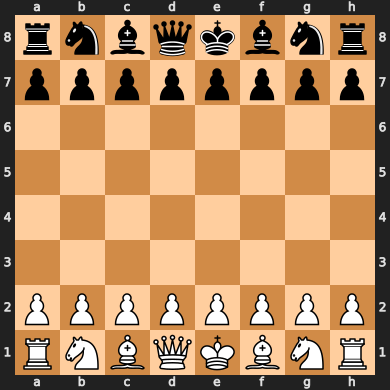

In [48]:
print(board)
board

In [125]:
board.push_san('b1c3')

Move.from_uci('b1c3')

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . N . . . . .
P P P P P P P P
R . B Q K B N R


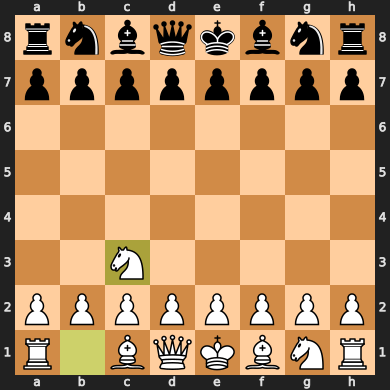

In [126]:
print(board)
board

(12, 8, 8)
bool


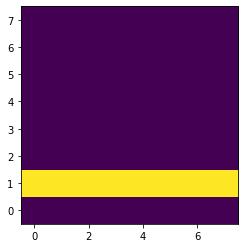

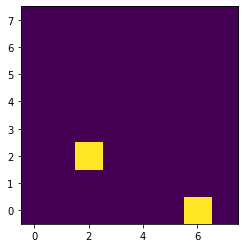

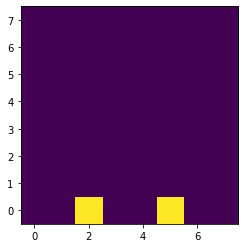

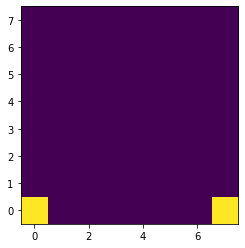

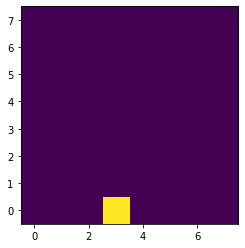

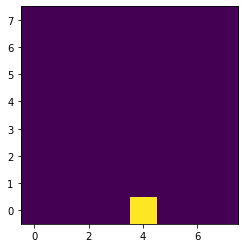

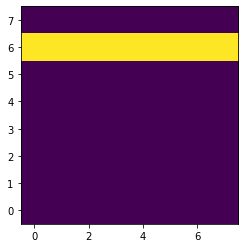

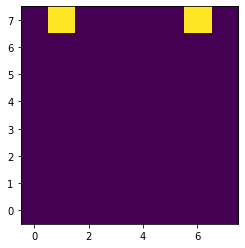

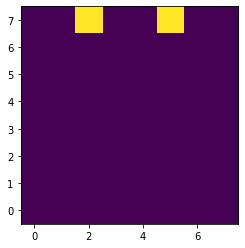

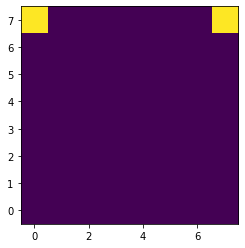

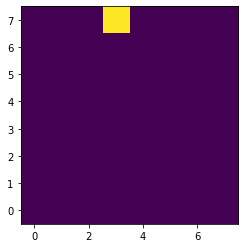

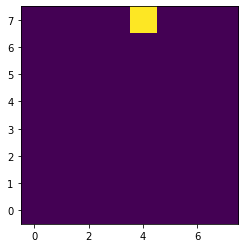

(12, 8, 8)


In [139]:
def uint64_to_uint8(a):
    ans = []
    for i in range(8):
        ans.append((a & (255<<(i*8)))>>(i*8))
    ans.reverse()
    return np.array(ans, dtype=np.uint8)

def get_representation(board):
    rep = []
    for player in [True, False]:
        for piece in range(1, 7):
            bitint = board.pieces_mask(piece, player)
            bitmask = np.unpackbits(uint64_to_uint8(bitint)[..., None], axis=-1).astype(bool)
            bitmask = np.flip(bitmask, axis=[0,1])
            rep.append(bitmask)
    return np.array(rep)


rep = get_representation(board)


print(rep.shape)
print(rep.dtype)

i=0
for player in [True, False]:
    for piece in range(1, 7):
        plt.imshow(rep[i])
        plt.ylim(-.5, 7.5)
        plt.show()
        i+=1
            
print(rep.shape) 